In [521]:
import sys
import json
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

In [112]:
def get_school_json(school):
    with open(sys.path[0] + f'/../data/{school}/{school}_w_profiles_detected_pct.json', 'r') as f:
        the_school = json.load(f)
    return the_school

In [113]:
school_names = ["columbia", "dartmouth", "yale", "princeton", "brown", "cornell", "upenn", "harvard"]

In [114]:
schools = {}
for school in school_names:
    schools[school] = get_school_json(school)

In [115]:
def get_feature_val(pct_data, category, feature):
    if pct_data.get(category) is None:
        return None
    else:
        return pct_data.get(category).get(feature)

In [116]:
# not including pctaian_name and pcthispanic_img
# only has pctaian from name 
def get_profile(profile):
    pct_data = profile.get('pct_data')
    prof_dict = {'index': profile.get('index'), 
                 'pctmale_name': get_feature_val(pct_data, 'gender_pct_name', 'pctmale'),
                 'pctmale_img': get_feature_val(pct_data, 'gender_pct_img', 'pctmale'),
                 'pctwhite_name': get_feature_val(pct_data, 'race_pct_name', 'pctwhite'),
                 'pctapi_name': get_feature_val(pct_data, 'race_pct_name', 'pctapi'),
                 'pctblack_name': get_feature_val(pct_data, 'race_pct_name', 'pctblack'),
                 'pcthispanic_name': get_feature_val(pct_data, 'race_pct_name', 'pcthispanic'),
                 'pctwhite_img': get_feature_val(pct_data, 'race_pct_img', 'pctwhite'),
                 'pctapi_img': get_feature_val(pct_data, 'race_pct_img', 'pctapi'),
                 'pctblack_img': get_feature_val(pct_data, 'race_pct_img', 'pctblack')
                }
    if 'race_labeled' not in profile.keys() or profile['race_labeled'] == 'unknown' or profile['gender_labeled'] == 'unknown':
        prof_dict['race_target'] = None
        prof_dict['gender_target'] = None
    else: 
        prof_dict['race_target'] = profile['race_labeled']
        prof_dict['gender_target'] = profile['gender_labeled']
    return prof_dict

In [117]:
profile_list = []
index = 0
for school in school_names:
    the_school = schools[school]
    for department in the_school:
        profiles = department.get('profiles')
        if profiles is not None:
            for prof in profiles:
                if prof.get('pct_data') is not None:
                    prof['index'] = index
                    profile_list.append(get_profile(prof))
                    index += 1

In [669]:
df = pd.DataFrame(profile_list).set_index('index')

In [670]:
df_labeled = df[pd.notnull(df['race_target'])]

In [671]:
df_labeled

,pctmale_name,pctmale_img,pctwhite_name,pctapi_name,pctblack_name,pcthispanic_name,pctwhite_img,pctapi_img,pctblack_img,race_target,gender_target
index,,,,,,,,,,,
25,0.693669,2.205466,56.663244,0.451745,39.507187,2.351129,2.345702e+01,9.543050e+00,3.892100e+00,black,female
26,0.297202,2.273915,69.002254,0.614628,26.623643,2.673632,2.654887e-01,5.819630e+00,8.356323e+01,black,female
28,99.585823,99.982530,71.926418,0.633623,23.444047,3.260092,6.411822e-01,9.179066e+00,7.697966e+01,black,male
29,1.715987,77.652425,65.271238,0.450358,31.535312,2.262027,2.276086e+00,2.741469e+01,4.634169e+01,black,female
30,99.497728,99.994028,NaN,NaN,NaN,NaN,1.250127e+00,2.718069e+01,5.629524e+01,black,male
...,...,...,...,...,...,...,...,...,...,...,...
12980,99.486973,99.997878,93.074820,3.118356,1.417434,1.873038,9.981297e+01,1.400021e-05,8.189770e-08,white,male
12983,0.081542,53.714746,94.779970,0.677795,2.225594,2.134547,9.495648e+01,2.924023e-02,7.272754e-04,white,female
13011,99.933027,99.999976,42.826221,0.432900,52.927231,3.019996,7.820126e+01,5.652465e+00,6.782344e-01,black,male


# Gender

In [552]:
df_labeled_gender = df_labeled.loc[:,['pctmale_name', 'pctmale_img', 'gender_target']]

In [553]:
df_labeled_gender = df_labeled_gender[pd.notnull(df_labeled_gender['pctmale_name']) & pd.notnull(df_labeled_gender['pctmale_img'])]

In [554]:
print(len(df_labeled_gender))

797


In [579]:
X_gender = df_labeled_gender.iloc[:, 0:-1]

In [580]:
y_gender = df_labeled_gender.iloc[:, -1]

In [581]:
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(
    X_gender, y_gender, test_size=0.33, random_state=42)

## Multinomial Naive Bayes

In [582]:
clf_gender_nb = MultinomialNB(fit_prior=False)
clf_gender_nb.fit(X_train_gender, y_train_gender)
y_pred_gender = clf_gender_nb.predict(X_test_gender)

In [583]:
sklearn.metrics.accuracy_score(y_test_gender, y_pred_gender)

0.8863636363636364

## Logistic

In [584]:
clf_gender_log = LogisticRegression(random_state=0)
clf_gender_log.fit(X_train_gender, y_train_gender)
y_pred_gender = clf_gender_log.predict(X_test_gender)

In [585]:
clf_gender_log.score(X_train_gender, y_train_gender)

0.9737335834896811

In [586]:
# logistic produce better results
sklearn.metrics.accuracy_score(y_test_gender, y_pred_gender)

0.9810606060606061

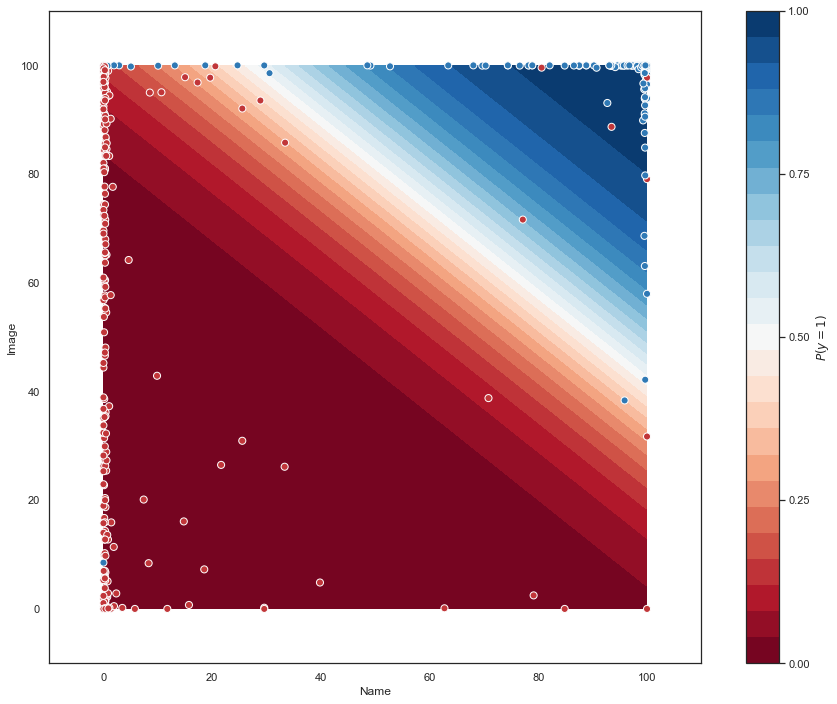

In [588]:
y_gender_binary = [1 if i == 'male' else 0 for i in y_gender]
# https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression
xx, yy = np.mgrid[0:100:.1, 0:100:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf_gender_log.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 12))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)

ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_gender['pctmale_name'], X_gender['pctmale_img'], c=y_gender_binary, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-10, 110), ylim=(-10, 110),
       xlabel="Name", ylabel="Image")
plt.show()

## Partial

In [589]:
df_labeled_gender = df_labeled.loc[:,['pctmale_name', 'pctmale_img', 'gender_target']]
df_gender_partial = df_labeled_gender[pd.isnull(df_labeled_gender['pctmale_name']) | pd.isnull(df_labeled_gender['pctmale_img'])]

In [590]:
y_pred_gender_partial = []
for i in df_gender_partial.index:
    if pd.isnull(df_gender_partial.loc[i, 'pctmale_name']) and pd.isnull(df_gender_partial.loc[i, 'pctmale_img']):
        y_pred_gender_partial.append('unknown')
    elif pd.notnull(df_gender_partial.loc[i, 'pctmale_name']):
        if df_gender_partial.loc[i, 'pctmale_name'] >= 50:
            y_pred_gender_partial.append('male')
        else:
            y_pred_gender_partial.append('female')
    else:
        if df_gender_partial.loc[i, 'pctmale_img'] >= 50:
            y_pred_gender_partial.append('male')
        else:
            y_pred_gender_partial.append('female')

In [593]:
print(f'For fully detected data ({len(y_test_gender)} for testing), the accuracy = {sklearn.metrics.accuracy_score(y_test_gender, y_pred_gender)}')
correct = 0
num_unknown = 0
for i in range(df_gender_partial.shape[0]):
    if y_pred_gender_partial[i] == 'unknown':
        num_unknown += 1
    elif df_gender_partial.iloc[i, -1] == y_pred_gender_partial[i]:
        correct += 1
print(f'For partially detected data ({df_gender_partial.shape[0] - num_unknown}), the accuracy = {correct/(df_gender_partial.shape[0] - num_unknown):.3f}')

For fully detected data (264 for testing), the accuracy = 0.9810606060606061
For partially detected data (252), the accuracy = 0.897


# Race

In [605]:
df_labeled_race = df_labeled.loc[:,['pctwhite_name', 'pctapi_name', 'pctblack_name', 'pcthispanic_name', 'pctwhite_img', 'pctapi_img', 'pctblack_img', 'race_target']]

In [606]:
df_labeled_race = df_labeled_race[pd.notnull(df_labeled_race['pctwhite_name']) & pd.notnull(df_labeled_race['pctwhite_img'])]

In [607]:
print(len(df_labeled_race))

786


In [608]:
X_race = df_labeled_race.iloc[:, 0:-1]

In [609]:
y_race = df_labeled_race.iloc[:, -1]

In [610]:
X_train_race, X_test_race, y_train_race, y_test_race = train_test_split(
    X_race, y_race, test_size=0.33, random_state=42)

In [611]:
clf_race = MultinomialNB(fit_prior=True)
clf_race.fit(X_train_race, y_train_race)
y_pred_race = clf_race.predict(X_test_race)

In [612]:
sklearn.metrics.accuracy_score(y_test_race, y_pred_race)

0.9115384615384615

# Partial data

In [620]:
df_labeled_race = df_labeled.loc[:,['pctwhite_name', 'pctapi_name', 'pctblack_name', 'pcthispanic_name', 'pctwhite_img', 'pctapi_img', 'pctblack_img', 'race_target']]
df_race_partial = df_labeled_race[pd.isnull(df_labeled_race['pctwhite_name']) | pd.isnull(df_labeled_race['pctwhite_img'])]

In [621]:
def get_category(s):
    tmp = s.split('_')[0]
    return tmp[3:]

In [626]:
y_pred_race_partial = []
for i in range(df_race_partial.shape[0]):
    if pd.isnull(df_race_partial.iloc[i, 0]) and pd.isnull(df_race_partial.iloc[i, 4]):
        y_pred_race_partial.append('unknown')
    # name
    elif pd.notnull(df_race_partial.iloc[i, 0]):
        tmp = df_race_partial.iloc[i, :4].astype('float64')
        if 100 - sum(tmp) > tmp.max():
            y_pred_race_partial.append('aian')
        else:
            s = tmp.idxmax()
            y_pred_race_partial.append(get_category(s))
    else:
        tmp = df_race_partial.iloc[i, 4:7].astype('float64')
        if 100 - sum(tmp) > tmp.max():
            y_pred_race_partial.append('hispanic')
        else:
            s = tmp.idxmax()
            y_pred_race_partial.append(get_category(s))

print(f'For fully detected data ({len(y_test_race)} for testing), the accuracy = {sklearn.metrics.accuracy_score(y_test_race, y_pred_race):.3f}')
num_unknown = 0
correct = 0
for i in range(df_race_partial.shape[0]):
    if y_pred_race_partial[i] == 'unknown':
        num_unknown += 1
    elif df_race_partial.iloc[i, -1] == y_pred_race_partial[i]:
        correct += 1
print(f'For partially detected data ({df_race_partial.shape[0] - num_unknown}), the accuracy = {correct/(df_race_partial.shape[0] - num_unknown):.3f}')

For fully detected data (260 for testing), the accuracy = 0.912
For partially detected data (245), the accuracy = 0.751


# Fit the model for all the data

In [627]:
def detect_gender(row, clf):
    if pd.notnull(row['gender_detected']):
        return row['gender_detected']
    elif pd.isnull(row['pctmale_name']) and pd.isnull(row['pctmale_img']):
        return 'unknown'
    elif pd.notnull(row['pctmale_name']) and pd.notnull(row['pctmale_img']):
        return clf.predict(np.array(row.iloc[:2]).reshape(1, -1))[0]
    elif pd.notnull(row['pctmale_name']):
        if row['pctmale_name'] >= 50:
            return 'male'
        else:
            return 'female'
    else:
        if row['pctmale_img'] >= 50:
            return 'male'
        else:
            return 'female'

In [650]:
def detect_race(row, clf):
    if pd.notnull(row['race_detected']):
        return row['race_detected']
    elif pd.isnull(row['pctwhite_name']) and pd.isnull(row['pctwhite_img']):
        return 'unknown'
    elif pd.notnull(row['pctwhite_name']) and pd.notnull(row['pctwhite_img']):
        return clf.predict(np.array(row.iloc[2:-2]).reshape(1, -1))[0]
    elif pd.notnull(row['pctwhite_name']):
        tmp = row.iloc[2:6].astype('float64')
        if 100 - sum(tmp) > tmp.max():
            return 'aian'
        else:
            s = tmp.idxmax()
            return get_category(s)
    else:
        tmp = row.iloc[6:-2].astype('float64')
        if 100 - sum(tmp) > tmp.max():
            return 'hispanic'
        else:
            s = tmp.idxmax()
            return get_category(s)

In [672]:
clf_gender = LogisticRegression(random_state=0)
clf_gender.fit(X_gender, y_gender)

LogisticRegression(random_state=0)

In [673]:
clf_race = MultinomialNB(fit_prior=True)
clf_race.fit(X_race, y_race)

MultinomialNB()

In [674]:
df = df.rename(columns = {'race_target' : 'race_detected', 'gender_target' : 'gender_detected'})

In [676]:
for i in df.index:
    df.iloc[i, -1] = detect_gender(df.iloc[i, :], clf_gender)

In [678]:
for i in df.index:
    df.iloc[i, -2] = detect_race(df.iloc[i, :], clf_race)

In [679]:
df.head(5)

,pctmale_name,pctmale_img,pctwhite_name,pctapi_name,pctblack_name,pcthispanic_name,pctwhite_img,pctapi_img,pctblack_img,race_detected,gender_detected
index,,,,,,,,,,,
0,99.774626,99.719268,NaN,NaN,NaN,NaN,95.945364,0.019835,0.000703,white,male
1,99.637479,99.966264,NaN,NaN,NaN,NaN,75.545019,0.492700,0.015279,white,male
2,100.000000,99.968219,95.589277,0.566515,1.274659,2.033384,99.259317,0.011073,0.000112,white,male
3,78.176796,0.019154,1.566952,97.507123,0.000000,0.925926,0.586976,99.370378,0.000010,api,female
4,99.585467,76.998234,53.906090,0.522862,42.782448,2.296494,40.101653,7.768338,1.107492,white,male


# Update the results to the dictionary

In [683]:
for school in school_names:
    the_school = schools[school]
    for department in the_school:
        profiles = department.get('profiles')
        if profiles is not None:
            for prof in profiles:
                index = prof.get('index')
                if index is not None:
                    prof.update({'race_detected': df.loc[index, 'race_detected'], 
                                 'gender_detected': df.loc[index, 'gender_detected']})
                else:
                    prof.update({'race_detected': 'unknown',
                                'gender_detected': 'unknown'})

In [685]:
schools['upenn'][0].get('profiles')[-1]

{'name': 'Tukufu Zuberi',
 'title': 'Lasry Family Professor of Race Relations',
 'img': 'https://africana.sas.upenn.edu/sites/default/files/styles/profile_wide/public/FLOzY7b4_0.jpg?itok=Ajp-x58X',
 'rank': 'professor',
 'first_name': 'Tukufu',
 'middle_name': None,
 'last_name': 'Zuberi',
 'pct_data': {'race_pct_name': {'pctwhite': 12.575536570118777,
   'pctapi': 77.24525942904774,
   'pctblack': 8.678891435715775,
   'pcthispanic': 1.500312565117733,
   'pctaian': 0.0},
  'gender_pct_name': None,
  'race_pct_img': {'pctwhite': 2.9903251476193834e-14,
   'pctblack': 100.0,
   'pctapi': 1.4778410717397605e-07,
   'pcthispanic': 1.9910757070862317e-09},
  'gender_pct_img': {'pctmale': 99.9106228351593,
   'pctfemale': 0.08937048260122538}},
 'index': 10283,
 'race_detected': 'black',
 'gender_detected': 'male'}

In [687]:
for school in school_names:
    with open(sys.path[0] + f'/../data/{school}/{school}_detected_pct.json', 'w') as f:
        json.dump(schools[school], f)